# 2018 FIFA World Cup Predictions!

In this notebook, we are going to develop machine learning models to predict World Cup 2018's outcomes!

The datasets are obtained from Kaggle (link ...). We are going to perform some exploratory analysis, then feature engineering, then data manipulation, choose the best model, and then deploy on the datasets.

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

## Read the datasets into dataframes
world_cup contains information about the participating teams in the tournament.
results contains records of all matches since the beginning of World Cup.

In [70]:
#load data 
world_cup = pd.read_csv('datasets/World Cup 2018 Dataset.csv')
results = pd.read_csv('datasets/results.csv')

world_cup dataframe consists of 33 rows (32 teams and 1 header) and 20 columns

In [71]:
world_cup.shape

(33, 20)

In [72]:
world_cup.head()

,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Porugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


results consists of 38902 rows (representing all the international matches) and 8 columns.

In [73]:
results.shape

(38902, 8)

In [74]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1,1873-03-08,England,Scotland,4,2,Friendly,London,England
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
3,1875-03-06,England,Scotland,2,2,Friendly,London,England
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


## Exploratory Analysis
We will need to combine the two datasets for our predictions. For example, "Current FIFA rank" in world_cup dataframe will play an important role in predicting future outcomes. Meanwhile, 'results' dataframe will provide insight about all the matches for one particular team, say team A, as well as its performance against some particular team B.

In [75]:
# adding new columns for data analysis, in this case the winner and goal difference of a game
winner = []
for i in range (len(results['home_team'])):
    if results ['home_score'][i] > results['away_score'][i]:
        winner.append(results['home_team'][i])
    elif results['home_score'][i] < results ['away_score'][i]:
        winner.append(results['away_team'][i])
    else:
        winner.append('Tie')
# adding 'winning_team' column to 'results' dataframe        
results['winning_team'] = winner

# adding 'goal_difference' column to 'results' dataframe
results['goal_difference'] = np.absolute(results['home_score'] - results['away_score'])

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,Tie,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Tie,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Scotland,3


We can start to think which factors we should focus on and which ones we should ignore. 
Does city play any important role? Most likely no. How about country? Yes if one team gets to play at its home country (But for World Cup all teams will play at some other host country, so I would get rid of 'country' as well).

We notice that there's "Friendly" in 'tournament'. From this we can start to think if 'tournament' is going to play any important role in the predictions? Personally, I think that many teams do not tend to play seriously in a "Friendly" tournament. So I might consider getting rid of all "Friendly" matches in later steps. 

In [112]:
tournament = results['tournament'].unique()
print(list(tournament))

['Friendly', 'British Championship', 'Copa Lipton', 'Copa Newton', 'Copa Premio Honor Argentino', 'Copa Premio Honor Uruguayo', 'Copa Roca', 'Copa América', 'Copa Chevallier Boutell', 'Nordic Championship', 'International Cup', 'Baltic Cup', 'Balkan Cup', 'FIFA World Cup', 'Copa Rio Branco', 'FIFA World Cup qualification', 'CCCF Championship', 'NAFU Championship', 'Copa Oswaldo Cruz', 'Pan American Championship', 'Copa del Pacífico', "Copa Bernardo O'Higgins", 'AFC Asian Cup qualification', 'Atlantic Cup', 'AFC Asian Cup', 'African Cup of Nations', 'Copa Paz del Chaco', 'Merdeka Tournament', 'UEFA Euro qualification', 'UEFA Euro', 'Windward Islands Tournament', 'African Cup of Nations qualification', 'Vietnam Independence Cup', 'Copa Carlos Dittborn', 'CONCACAF Championship', 'Copa Juan Pinto Durán', 'UAFA Cup', 'South Pacific Games', 'CONCACAF Championship qualification', 'Copa Artigas', 'GaNEFo', "King's Cup", 'Gulf Cup', 'Indonesia Tournament', 'Korea Cup', 'Brazil Independence Cup'

How many teams are there in the 'results' data set? 245

In [77]:
home_team_total = list(results['home_team'].unique())
away_team_total = list(results['away_team'].unique())
team_total = list(set(home_team_total + away_team_total))
team_total.sort()
len(team_total)

245

How many teams have played in World Cup since the beginning? 79

In [110]:
df_world_cup = results[results['tournament'] == 'FIFA World Cup']
home_team_world_cup = list(df_world_cup['home_team'].unique())
away_team_world_cup = list(df_world_cup['away_team'].unique())
world_cup_team_total = list(set(home_team_world_cup + away_team_world_cup))
print(len(world_cup_team_total))
print(world_cup_team_total)

79
['Denmark', 'Yugoslavia', 'South Africa', 'Russia', 'Hungary', 'Congo DR', 'Colombia', 'Australia', 'Bolivia', 'United Arab Emirates', 'El Salvador', 'Honduras', 'Iran', 'Poland', 'Iraq', 'Saudi Arabia', 'Germany', 'Serbia', 'Senegal', 'Spain', 'Italy', 'Ghana', 'Sweden', 'Norway', 'German DR', 'Ecuador', 'Wales', 'Kuwait', 'Ukraine', 'Turkey', 'China', 'Cameroon', 'New Zealand', 'Canada', 'USA', 'Japan', 'Romania', 'Korea Republic', 'Algeria', 'Morocco', 'Croatia', 'Tunisia', 'Costa Rica', 'Slovakia', 'Brazil', 'Chile', 'Togo', 'Korea DPR', 'France', 'Mexico', 'Indonesia', 'Cuba', 'Belgium', 'Switzerland', 'Angola', 'Ireland', 'Netherlands', 'Portugal', 'Jamaica', 'Bosnia-Herzegovina', 'Czechoslovakia', 'Egypt', 'Haiti', 'England', 'Slovenia', 'Trinidad and Tobago', 'Argentina', 'Bulgaria', 'Ivory Coast', 'Greece', 'Paraguay', 'Peru', 'Nigeria', 'Northern Ireland', 'Austria', 'Israel', 'Uruguay', 'Scotland', 'Czech Republic']


Let's play around with the data by focusing on one of my favorite team, say Argentina.

In [78]:
# slice the dataset to create the 'argentina' dataframe
df = results[(results['home_team'] == 'Argentina') | (results['away_team'] == 'Argentina')]
argentina = df.iloc[:]
argentina.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
144,1902-07-20,Uruguay,Argentina,0,6,Friendly,Montevideo,Uruguay,Argentina,6
152,1903-09-13,Argentina,Uruguay,2,3,Friendly,Buenos Aires,Argentina,Uruguay,1
173,1905-08-15,Argentina,Uruguay,0,0,Copa Lipton,Buenos Aires,Argentina,Tie,0
184,1906-08-15,Uruguay,Argentina,0,2,Copa Lipton,Montevideo,Uruguay,Argentina,2
186,1906-10-21,Argentina,Uruguay,2,1,Copa Newton,Buenos Aires,Argentina,Argentina,1


Extract all matches after 1930 of the data, since we only care about matches since the 1st World Cup, which is 1930. 

In [79]:
# adding a column for year and the first world cup was held in 1930
year = []
# getting the year out of each date
for row in argentina['date']:
    year.append(int(row[:4]))
    
argentina['match_year']= year

argentina_1930 = argentina[argentina['match_year'] >= 1930]
argentina_1930.count()

date               800
home_team          800
away_team          800
home_score         800
away_score         800
tournament         800
city               800
country            800
winning_team       800
goal_difference    800
match_year         800
dtype: int64

So Argentina has played in total 800 international matches since 1930. Let's visualize their results!

([<matplotlib.axis.XTick at 0x2165d0b86a0>],
 <a list of 1 Text xticklabel objects>)

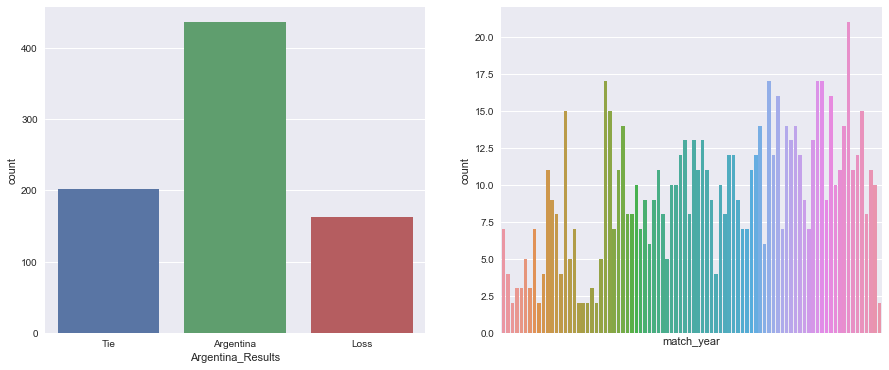

In [114]:
# (histogram) visualization of win-tie-loss games for argentina

winning_rate = []
for row in argentina_1930['winning_team']:
    if row != 'Argentina' and row != 'Tie':
        winning_rate.append('Loss')
    else:
        winning_rate.append(row)
winning_df= pd.DataFrame(winning_rate, columns=[ 'Argentina_Results'])

# plotting using seaborn
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 6)
sns.set(style='darkgrid')
sns.countplot(x='Argentina_Results', data=winning_df, ax=ax[0])
sns.countplot(x='match_year', data=argentina_1930, ax=ax[1])
plt.xticks(np.arange(min(argentina_1930.match_year), max(argentina_1930.match_year), 100))

In [120]:
argentina_1930.groupby('match_year').count()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
match_year,,,,,,,,,,
1930,7,7,7,7,7,7,7,7,7,7
1931,4,4,4,4,4,4,4,4,4,4
1932,2,2,2,2,2,2,2,2,2,2
1933,3,3,3,3,3,3,3,3,3,3
1934,3,3,3,3,3,3,3,3,3,3
1935,5,5,5,5,5,5,5,5,5,5
1936,3,3,3,3,3,3,3,3,3,3
1937,7,7,7,7,7,7,7,7,7,7
1938,2,2,2,2,2,2,2,2,2,2


What if we want to narrow down our focus on all World Cup games of Argentina since 1930?

In [123]:
argentina_1930_world_cup = argentina_1930[argentina_1930['tournament'] == 'FIFA World Cup']
argentina_1930_world_cup

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference,match_year
1281,1930-07-15,Argentina,France,1,0,FIFA World Cup,Montevideo,Uruguay,Argentina,1,1930
1287,1930-07-19,Argentina,Mexico,6,3,FIFA World Cup,Montevideo,Uruguay,Argentina,3,1930
1292,1930-07-22,Argentina,Chile,3,1,FIFA World Cup,Montevideo,Uruguay,Argentina,2,1930
1294,1930-07-26,Argentina,USA,6,1,FIFA World Cup,Montevideo,Uruguay,Argentina,5,1930
1296,1930-07-30,Uruguay,Argentina,4,2,FIFA World Cup,Montevideo,Uruguay,Uruguay,2,1930
1649,1934-05-27,Argentina,Sweden,2,3,FIFA World Cup,Bologna,Italy,Sweden,1,1934
4295,1958-06-08,Argentina,Germany,1,3,FIFA World Cup,Malmö,Sweden,Germany,2,1958
4303,1958-06-11,Argentina,Northern Ireland,3,1,FIFA World Cup,Halmstad,Sweden,Argentina,2,1958
4311,1958-06-15,Argentina,Czechoslovakia,1,6,FIFA World Cup,Helsingborg,Sweden,Czechoslovakia,5,1958
5062,1962-05-30,Argentina,Bulgaria,1,0,FIFA World Cup,Rancagua,Chile,Argentina,1,1962


How many games did Argentina play in World Cup 1986? 7 (straight to the final and won)

In [157]:
argentina_1930_world_cup.groupby('match_year').count()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
match_year,,,,,,,,,,
1930,5,5,5,5,5,5,5,5,5,5
1934,1,1,1,1,1,1,1,1,1,1
1958,3,3,3,3,3,3,3,3,3,3
1962,3,3,3,3,3,3,3,3,3,3
1966,4,4,4,4,4,4,4,4,4,4
1974,6,6,6,6,6,6,6,6,6,6
1978,7,7,7,7,7,7,7,7,7,7
1982,5,5,5,5,5,5,5,5,5,5
1986,7,7,7,7,7,7,7,7,7,7


# Analyze
Win rate (based on historical matches) should be usefule in our analysis and in predicting the outcomes of matches in the World Cup tournament. Other than that, results from direct matches against each other would play certain role as well. 

As mentioned above, we are going to drop unimportant columns, such as 'city', 'country'. And we also exclude "Friendly" matches from 'tournament' column in our historical data.



In [152]:
#narrowing to team patcipating in the world cup
worldcup_teams = ['Australia', ' Iran', 'Japan', 'Korea Republic', 
            'Saudi Arabia', 'Egypt', 'Morocco', 'Nigeria', 
            'Senegal', 'Tunisia', 'Costa Rica', 'Mexico', 
            'Panama', 'Argentina', 'Brazil', 'Colombia', 
            'Peru', 'Uruguay', 'Belgium', 'Croatia', 
            'Denmark', 'England', 'France', 'Germany', 
            'Iceland', 'Poland', 'Portugal', 'Russia', 
            'Serbia', 'Spain', 'Sweden', 'Switzerland']
df_teams_home = results[results['home_team'].isin(worldcup_teams)]
df_teams_away = results[results['away_team'].isin(worldcup_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams.drop_duplicates()
df_teams.count()

date               20565
home_team          20565
away_team          20565
home_score         20565
away_score         20565
tournament         20565
city               20565
country            20565
winning_team       20565
goal_difference    20565
dtype: int64

In [128]:
df_teams.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Tie,0
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,Scotland,2
10,1879-01-18,England,Wales,2,1,Friendly,London,England,England,1
11,1879-04-05,England,Scotland,5,4,Friendly,London,England,England,1


In [129]:
#create an year column to drop games before 1930
year = []
for row in df_teams['date']:
    year.append(int(row[:4]))
df_teams['match_year'] = year
df_teams_1930 = df_teams[df_teams.match_year >= 1930]
df_teams_1930.count()

date               19472
home_team          19472
away_team          19472
home_score         19472
away_score         19472
tournament         19472
city               19472
country            19472
winning_team       19472
goal_difference    19472
match_year         19472
dtype: int64

In [130]:
#dropping columns that wll not affect matchoutcomes
#df_teams_1930 = df_teams_1930.drop(['date', 'home_score', 'away_score', 'tournament', 'city', 'country', 'goal_difference', 'match_year'], axis=1)
df1 = df_teams_1930.sort_values(by=['home_team'])
df1[df1['home_team'] == 'Albania'].count()
#df_teams_1930.groupby(['home_team']).count()

date               43
home_team          43
away_team          43
home_score         43
away_score         43
tournament         43
city               43
country            43
winning_team       43
goal_difference    43
match_year         43
dtype: int64

In [131]:
df_teams_1930.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference,match_year
1230,1930-01-01,Spain,Czechoslovakia,1,0,Friendly,Barcelona,Spain,Spain,1,1930
1231,1930-01-12,Portugal,Czechoslovakia,1,0,Friendly,Lisbon,Portugal,Portugal,1,1930
1237,1930-02-23,Portugal,France,2,0,Friendly,Porto,Portugal,Portugal,2,1930
1238,1930-03-02,Germany,Italy,0,2,Friendly,Frankfurt am Main,Germany,Italy,2,1930
1240,1930-03-23,France,Switzerland,3,3,Friendly,Colombes,France,Tie,0,1930


In [135]:
#Building the model
#the prediction label: The winning_team column will show "2" if the home team has won, "1" if it was a tie, and "0" if the away team has won.

df_teams_1930 = df_teams_1930.reset_index(drop=True)
df_teams_1930.loc[df_teams_1930.winning_team == df_teams_1930.home_team,'winning_team']=2
df_teams_1930.loc[df_teams_1930.winning_team == 'Tie', 'winning_team']=1
df_teams_1930.loc[df_teams_1930.winning_team == df_teams_1930.away_team, 'winning_team']=0

df_teams_1930.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference,match_year
0,1930-01-01,Spain,Czechoslovakia,1,0,Friendly,Barcelona,Spain,2,1,1930
1,1930-01-12,Portugal,Czechoslovakia,1,0,Friendly,Lisbon,Portugal,2,1,1930
2,1930-02-23,Portugal,France,2,0,Friendly,Porto,Portugal,2,2,1930
3,1930-03-02,Germany,Italy,0,2,Friendly,Frankfurt am Main,Germany,0,2,1930
4,1930-03-23,France,Switzerland,3,3,Friendly,Colombes,France,1,0,1930


In [136]:
#convert home team and away team from categorical variables to continous inputs 
# Get dummy variables
final = pd.get_dummies(df_teams_1930, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Separate X and y sets
X = final.drop(['winning_team'], axis=1)
y = final["winning_team"]
y = y.astype('int')

# Separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [137]:
final.head()

,date,home_score,away_score,tournament,city,country,winning_team,goal_difference,match_year,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,home_team_Australia,home_team_Austria,home_team_Azerbaijan,home_team_Bahrain,home_team_Bangladesh,home_team_Barbados,home_team_Belarus,home_team_Belgium,...,away_team_Tajikistan,away_team_Tanzania,away_team_Thailand,away_team_Togo,away_team_Trinidad and Tobago,away_team_Tunisia,away_team_Turkey,away_team_Turkmenistan,away_team_USA,away_team_Uganda,away_team_Ukraine,away_team_United Arab Emirates,away_team_Uruguay,away_team_Uzbekistan,away_team_Vanuatu,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,1930-01-01,1,0,Friendly,Barcelona,Spain,2,1,1930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1930-01-12,1,0,Friendly,Lisbon,Portugal,2,1,1930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1930-02-23,2,0,Friendly,Porto,Portugal,2,2,1930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1930-03-02,0,2,Friendly,Frankfurt am Main,Germany,0,2,1930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1930-03-23,3,3,Friendly,Colombes,France,1,0,1930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [138]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
score = logreg.score(X_train, y_train)
score2 = logreg.score(X_test, y_test)

print("Training set accuracy: ", '%.3f'%(score))
print("Test set accuracy: ", '%.3f'%(score2))

ValueError: could not convert string to float: 'England'

In [139]:
#adding Fifa rankings
#the team which is positioned higher on the FIFA Ranking will be considered "favourite" for the match
#and therefore, will be positioned under the "home_teams" column
#since there are no "home" or "away" teams in World Cup games. 

# Loading new datasets
ranking = pd.read_csv('datasets/fifa_rankings.csv') 
fixtures = pd.read_csv('datasets/fixtures.csv')

# List for storing the group stage games
pred_set = []

In [140]:
# Create new columns with ranking position of each team
fixtures.insert(1, 'first_position', fixtures['Home Team'].map(ranking.set_index('Team')['Position']))
fixtures.insert(2, 'second_position', fixtures['Away Team'].map(ranking.set_index('Team')['Position']))

# We only need the group stage games, so we have to slice the dataset
fixtures = fixtures.iloc[:48, :]
fixtures.tail()

,Round Number,first_position,second_position,Date,Location,Home Team,Away Team,Group,Result
43,3,6.0,25.0,27/06/2018 21:00,Nizhny Novgorod Stadium,Switzerland,Costa Rica,Group E,NaN
44,3,60.0,10.0,28/06/2018 17:00,Volgograd Stadium,Japan,Poland,Group H,NaN
45,3,28.0,16.0,28/06/2018 17:00,Samara Stadium,Senegal,Colombia,Group H,NaN
46,3,55.0,14.0,28/06/2018 21:00,Saransk Stadium,Panama,Tunisia,Group G,NaN
47,3,13.0,3.0,28/06/2018 21:00,Kaliningrad Stadium,England,Belgium,Group G,NaN


In [141]:
# Loop to add teams to new prediction dataset based on the ranking position of each team
for index, row in fixtures.iterrows():
    if row['first_position'] < row['second_position']:
        pred_set.append({'home_team': row['Home Team'], 'away_team': row['Away Team'], 'winning_team': None})
    else:
        pred_set.append({'home_team': row['Away Team'], 'away_team': row['Home Team'], 'winning_team': None})
        
pred_set = pd.DataFrame(pred_set)
backup_pred_set = pred_set

pred_set.head()

,away_team,home_team,winning_team
0,Saudi Arabia,Russia,None
1,Egypt,Uruguay,None
2,Morocco,Iran,None
3,Spain,Portugal,None
4,Australia,France,None


In [142]:
# Get dummy variables and drop winning_team column
pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Add missing columns compared to the model's training dataset
missing_cols = set(final.columns) - set(pred_set.columns)
for c in missing_cols:
    pred_set[c] = 0
pred_set = pred_set[final.columns]

# Remove winning team column
pred_set = pred_set.drop(['winning_team'], axis=1)

pred_set.head()

,date,home_score,away_score,tournament,city,country,goal_difference,match_year,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_Andorra,home_team_Angola,home_team_Argentina,home_team_Armenia,home_team_Aruba,home_team_Australia,home_team_Austria,home_team_Azerbaijan,home_team_Bahrain,home_team_Bangladesh,home_team_Barbados,home_team_Belarus,home_team_Belgium,home_team_Belize,...,away_team_Tajikistan,away_team_Tanzania,away_team_Thailand,away_team_Togo,away_team_Trinidad and Tobago,away_team_Tunisia,away_team_Turkey,away_team_Turkmenistan,away_team_USA,away_team_Uganda,away_team_Ukraine,away_team_United Arab Emirates,away_team_Uruguay,away_team_Uzbekistan,away_team_Vanuatu,away_team_Venezuela,away_team_Vietnam,away_team_Vietnam Republic,away_team_Wales,away_team_Western Australia,away_team_Yemen,away_team_Yemen DPR,away_team_Yugoslavia,away_team_Zambia,away_team_Zimbabwe
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [143]:
#group matches 
predictions = logreg.predict(pred_set)
for i in range(fixtures.shape[0]):
    print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
    if predictions[i] == 2:
        print("Winner: " + backup_pred_set.iloc[i, 1])
    elif predictions[i] == 1:
        print("Draw")
    elif predictions[i] == 0:
        print("Winner: " + backup_pred_set.iloc[i, 0])
    print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
    print('Probability of Draw: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
    print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
    print("")

NotFittedError: This LogisticRegression instance is not fitted yet

In [144]:
# List of tuples before 
group_16 = [('Uruguay', 'Portugal'),
            ('France', 'Croatia'),
            ('Brazil', 'Mexico'),
            ('England', 'Colombia'),
            ('Spain', 'Russia'),
            ('Argentina', 'Peru'),
            ('Germany', 'Switzerland'),
            ('Poland', 'Belgium')]

In [145]:
def clean_and_predict(matches, ranking, final, logreg):

    # Initialization of auxiliary list for data cleaning
    positions = []

    # Loop to retrieve each team's position according to FIFA ranking
    for match in matches:
        positions.append(ranking.loc[ranking['Team'] == match[0],'Position'].iloc[0])
        positions.append(ranking.loc[ranking['Team'] == match[1],'Position'].iloc[0])
    
    # Creating the DataFrame for prediction
    pred_set = []

    # Initializing iterators for while loop
    i = 0
    j = 0

    # 'i' will be the iterator for the 'positions' list, and 'j' for the list of matches (list of tuples)
    while i < len(positions):
        dict1 = {}

        # If position of first team is better, he will be the 'home' team, and vice-versa
        if positions[i] < positions[i + 1]:
            dict1.update({'home_team': matches[j][0], 'away_team': matches[j][1]})
        else:
            dict1.update({'home_team': matches[j][1], 'away_team': matches[j][0]})

        # Append updated dictionary to the list, that will later be converted into a DataFrame
        pred_set.append(dict1)
        i += 2
        j += 1

    # Convert list into DataFrame
    pred_set = pd.DataFrame(pred_set)
    backup_pred_set = pred_set

    # Get dummy variables and drop winning_team column
    pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

    # Add missing columns compared to the model's training dataset
    missing_cols2 = set(final.columns) - set(pred_set.columns)
    for c in missing_cols2:
        pred_set[c] = 0
    pred_set = pred_set[final.columns]

    # Remove winning team column
    pred_set = pred_set.drop(['winning_team'], axis=1)

    # Predict!
    predictions = logreg.predict(pred_set)
    for i in range(len(pred_set)):
        print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
        if predictions[i] == 2:
            print("Winner: " + backup_pred_set.iloc[i, 1])
        elif predictions[i] == 1:
            print("Draw")
        elif predictions[i] == 0:
            print("Winner: " + backup_pred_set.iloc[i, 0])
        print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ' , '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
        print('Probability of Draw: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1])) 
        print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
        print("")

In [65]:
clean_and_predict(group_16, ranking, final, logreg)

Portugal and Uruguay
Winner: Portugal
Probability of Portugal winning:  0.428
Probability of Draw:  0.285
Probability of Uruguay winning:  0.287

France and Croatia
Winner: France
Probability of France winning:  0.481
Probability of Draw:  0.252
Probability of Croatia winning:  0.267

Brazil and Mexico
Winner: Brazil
Probability of Brazil winning:  0.695
Probability of Draw:  0.209
Probability of Mexico winning:  0.096

England and Colombia
Winner: England
Probability of England winning:  0.516
Probability of Draw:  0.368
Probability of Colombia winning:  0.116

Spain and Russia
Winner: Spain
Probability of Spain winning:  0.529
Probability of Draw:  0.280
Probability of Russia winning:  0.191

Argentina and Peru
Winner: Argentina
Probability of Argentina winning:  0.713
Probability of Draw:  0.212
Probability of Peru winning:  0.075

Germany and Switzerland
Winner: Germany
Probability of Germany winning:  0.672
Probability of Draw:  0.192
Probability of Switzerland winning:  0.137

Be

In [146]:
# List of matches
quarters = [('Portugal', 'France'),
            ('Spain', 'Argentina'),
            ('Brazil', 'England'),
            ('Germany', 'Belgium')]

In [147]:
clean_and_predict(quarters, ranking, final, logreg)

NotFittedError: This LogisticRegression instance is not fitted yet

In [148]:
# List of matches
semi = [('Portugal', 'Brazil'),
        ('Argentina', 'Germany')]

In [149]:
clean_and_predict(semi, ranking, final, logreg)

NotFittedError: This LogisticRegression instance is not fitted yet

In [150]:
# Finals
finals = [('Brazil', 'Germany')]

In [151]:
clean_and_predict(finals, ranking, final, logreg)

NotFittedError: This LogisticRegression instance is not fitted yet